In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import json
from datasets import load_dataset
import os

dataset = load_dataset("gsm8k", "main")
train_questions = np.array(dataset["train"]["question"])
train_answers = np.array(dataset["train"]['answer'])

test_questions = np.array(dataset["test"]["question"])
test_answers = np.array(dataset["test"]['answer'])

In [7]:

plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': 'DejaVu Serif',
})

In [2]:
from palettable.cartocolors.qualitative import Prism_9



color_dict = {}

color_dict["2e-4"] = Prism_9.mpl_colors[2]
color_dict["5e-4"] = Prism_9.mpl_colors[3]
color_dict["2e-5"] = Prism_9.mpl_colors[4]
color_dict["5e-5"] = Prism_9.mpl_colors[5]
color_dict["5e-6"] = Prism_9.mpl_colors[6]
color_dict["5e-7"] = Prism_9.mpl_colors[7]

In [2]:
def get_stats(train_name):
    train_accs_all = []
    perplexities_all = []


    ckpts = sorted([
    f for f in os.listdir("ckpts/"+train_name) if os.path.isdir(os.path.join("ckpts/"+train_name, f))
    ], key=lambda x: int(x.split('-')[1]))
    # print(ckpts)

    for ckpt in ckpts:
        try:
            train_correct = (np.load("ckpts/"+train_name+"/"+ckpt+ "/train_answer_types5_seed2_temp0.8.npy")==0)
            
        except:
            try:
                train_correct = (np.load("ckpts/"+train_name+"/"+ckpt+ "/train_answer_types50_seed2_temp0.8.npy")==0)
            except:
                try:
                    train_correct = (np.load("ckpts/"+train_name+"/"+ckpt+ "/train_answer_types5_seed2.npy")==0)
                except:
                    train_correct = (np.load("ckpts/"+train_name+"/"+ckpt+ "/train_answer_types10_seed2_temp0.8.npy")==0)
        train_accs = train_correct.mean(axis=-1)
        train_accs_all.append(train_accs)
        
        perplexities = np.load("ckpts/"+train_name+"/"+ckpt+ "/train_perplexities.npy")
        perplexities_all.append(perplexities)
        
    if "full" not in train_name:
        subsample_idxs = np.load("ckpts/"+train_name+"/subsample_idxs.npy")
    else:
        subsample_idxs = np.arange(len(train_questions))
    
    train_accs_all = np.array(train_accs_all)[:, subsample_idxs]
    perplexities_all = np.array(perplexities_all)[:, subsample_idxs]
    
    
    
    test_accs_all = []

    for ckpt in ckpts:
        try:
            test_accs = (np.load("ckpts/"+train_name+"/"+ckpt+ "/test_answer_types50_seed2.npy")==0)
        except:
            try:
                test_accs = (np.load("ckpts/"+train_name+"/"+ckpt+ "/test_answer_types50_seed2_temp0.8.npy")==0)
            except:
                try:
                    test_accs = (np.load("ckpts/"+train_name+"/"+ckpt+ "/test_answer_types5_seed2_temp0.8.npy")==0)
                except:
                    test_accs = (np.load("ckpts/"+train_name+"/"+ckpt+ "/test_answer_types5_seed2.npy")==0)
        test_accs_all.append(test_accs)

    test_accs_all = np.array(test_accs_all)
    
    return_dict = {}
    return_dict["train_accs_all"] = train_accs_all
    return_dict["perplexities_all"] = perplexities_all
    return_dict["test_accs_all"] = test_accs_all
    
    return return_dict




def get_ratios2(stats_dict, perp_threshold=-2.5):
    train_accs_all = stats_dict["train_accs_all"]
    perplexities_all = stats_dict["perplexities_all"]
    test_accs_all = stats_dict["test_accs_all"]
    
    memorization_mask = np.ones(train_accs_all.shape)*-1
    accs_all = np.ones(train_accs_all.shape)*-1
    
    for i in range(len(train_accs_all)):

        accs_all[i] =train_accs_all[i]
        
        memorization_mask[i] = (np.log(np.log((perplexities_all[i]))) >= perp_threshold)
    
    
    
    
    unmemorized_acc_cummax = np.array([(accs_all*memorization_mask)[:j+1].max(axis=0) for j in range(len(train_accs_all))])
    
    # print(unmemorized_acc_cummax.shape)
    # print(accs_all.shape)
    unmemorized_acc_cummax = (np.min([unmemorized_acc_cummax, accs_all], axis=0))
    unmemorized_acc_cummax_mean = unmemorized_acc_cummax.mean(axis=1)
    

    avg_test_acc = test_accs_all.mean(axis=1).mean(axis=1)
    
    
    
    return_dict = {} 
    
    
    return_dict["unmemorized_acc_cummax"] = unmemorized_acc_cummax_mean
    return_dict["unmemorized_acc_cummax_all"] = unmemorized_acc_cummax

    return_dict["avg_test_acc"] = avg_test_acc
            
    return return_dict


In [3]:
# stats_dict5_3 = get_stats("gsm8k_orig_3epochs_full_lr5e-05_bs128")
stats_dict52_3 = get_stats("gsm8k_orig_3epochs_shuffle1_lr2e-05_bs128")
stats_dict7_3 = get_stats("gsm8k_orig_3epochs_full_lr5e-07_bs128")
stats_dict4_3 = get_stats("gsm8k_orig_3epochs_full_lr0.0002_bs128")

In [4]:
perp_threshold=-2.3
ratios_dict52_3 =  get_ratios2(stats_dict52_3, perp_threshold=perp_threshold)
ratios_dict7_3 =  get_ratios2(stats_dict7_3, perp_threshold=perp_threshold)
ratios_dict4_3 =  get_ratios2(stats_dict4_3, perp_threshold=perp_threshold)

Text(0.5, 1.0, 'GSM8k / Llama3 8B')

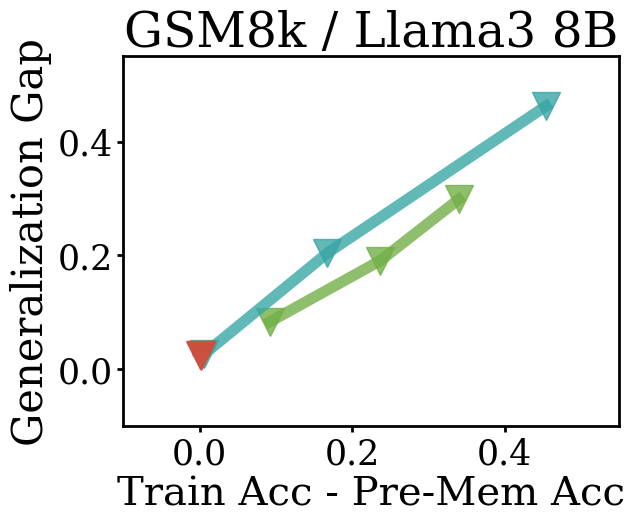

In [33]:
# plt.plot(ratios_dict5_3["unmemorized_acc_cummax"], ratios_dict5_3["avg_test_acc"], "v-", markersize=10, c="C0", alpha=0.8, label="lr 5e-5 epochs 3")

plt.plot(stats_dict52_3["train_accs_all"].mean(axis=1)-ratios_dict52_3["unmemorized_acc_cummax"], stats_dict52_3["train_accs_all"].mean(axis=1)-ratios_dict52_3["avg_test_acc"], "v-", markersize=20, linewidth = 8, c=color_dict["2e-5"], alpha=0.8, label="lr 2e-5")
plt.plot(stats_dict4_3["train_accs_all"].mean(axis=1)-ratios_dict4_3["unmemorized_acc_cummax"], stats_dict4_3["train_accs_all"].mean(axis=1)-ratios_dict4_3["avg_test_acc"], "v-", markersize=20, linewidth = 8, c=color_dict["2e-4"], alpha=0.8, label="lr 2e-4")
plt.plot(stats_dict7_3["train_accs_all"].mean(axis=1)-ratios_dict7_3["unmemorized_acc_cummax"], stats_dict7_3["train_accs_all"].mean(axis=1)-ratios_dict7_3["avg_test_acc"], "v-", markersize=20, linewidth = 8, c=color_dict["5e-7"], alpha=0.8, label="lr 5e-7")


plt.xlim(-0.1, 0.55)
plt.ylim(-0.1, 0.55)

plt.xticks([0, 0.2, 0.4], fontsize=25)
plt.yticks([0, 0.2, 0.4], fontsize=25)

#border width
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.tick_params(width=2, length=4)

plt.xlabel("Train Acc - Pre-Mem Acc", fontsize=29)
plt.ylabel("Generalization Gap", fontsize=30)
plt.title("GSM8k / Llama3 8B", fontsize=35)

In [20]:
x = np.concatenate([stats_dict52_3["train_accs_all"].mean(axis=1)-ratios_dict52_3["unmemorized_acc_cummax"],
                    stats_dict4_3["train_accs_all"].mean(axis=1)-ratios_dict4_3["unmemorized_acc_cummax"],
                    stats_dict7_3["train_accs_all"].mean(axis=1)-ratios_dict7_3["unmemorized_acc_cummax"]])

y = np.concatenate([stats_dict52_3["train_accs_all"].mean(axis=1)-ratios_dict52_3["avg_test_acc"],
                    stats_dict4_3["train_accs_all"].mean(axis=1)-ratios_dict4_3["avg_test_acc"],
                    stats_dict7_3["train_accs_all"].mean(axis=1)-ratios_dict7_3["avg_test_acc"]])

from scipy.stats import pearsonr

print(pearsonr(x, y))

PearsonRResult(statistic=0.9863736059831321, pvalue=9.59627677866189e-07)


In [11]:
ckpts = [58, 116, 174]

file_name = "gsm8k_orig_3epochs_full2_lr0.0002_bs128"
grad_vars_4 = []
for ckpt in ckpts:
    grad_var = np.load(f"ckpts/{file_name}/checkpoint-{ckpt}/grad_var.npy")
    grad_vars_4.append(grad_var)
    
file_name = "gsm8k_orig_3epochs_full2_lr2e-05_bs128"
grad_vars_52 = []
for ckpt in ckpts:
    grad_var = np.load(f"ckpts/{file_name}/checkpoint-{ckpt}/grad_var.npy")
    grad_vars_52.append(grad_var)

file_name = "gsm8k_orig_3epochs_full2_lr5e-07_bs128"
grad_vars_7 = []
for ckpt in ckpts:
    grad_var = np.load(f"ckpts/{file_name}/checkpoint-{ckpt}/grad_var.npy")
    grad_vars_7.append(grad_var)

Text(0.5, 1.0, 'GSM8k / Llama3 8B')

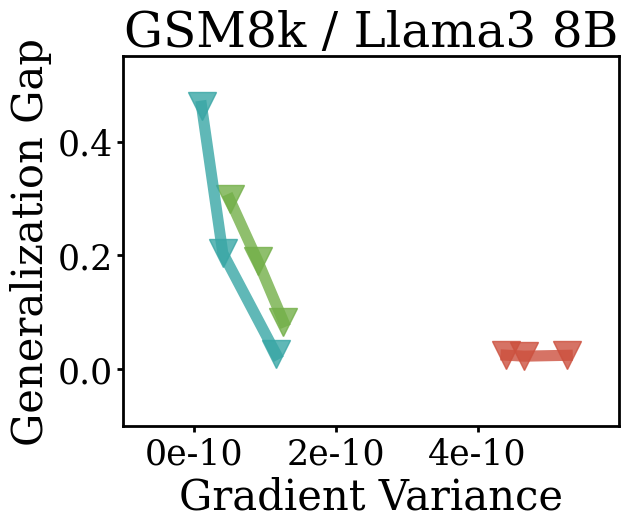

In [34]:
# plt.plot(ratios_dict5_3["unmemorized_acc_cummax"], ratios_dict5_3["avg_test_acc"], "v-", markersize=10, c="C0", alpha=0.8, label="lr 5e-5 epochs 3")
fig, ax = plt.subplots()
plt.plot(grad_vars_52, stats_dict52_3["train_accs_all"].mean(axis=1)-ratios_dict52_3["avg_test_acc"], "v-", markersize=20, linewidth = 8, c=color_dict["2e-5"], alpha=0.8, label="lr 2e-5")
plt.plot(grad_vars_4, stats_dict4_3["train_accs_all"].mean(axis=1)-ratios_dict4_3["avg_test_acc"], "v-", markersize=20, linewidth = 8, c=color_dict["2e-4"], alpha=0.8, label="lr 2e-4")
plt.plot(grad_vars_7, stats_dict7_3["train_accs_all"].mean(axis=1)-ratios_dict7_3["avg_test_acc"], "v-", markersize=20, linewidth = 8, c=color_dict["5e-7"], alpha=0.8, label="lr 5e-7")


plt.xlim(-1e-10, 6e-10)
plt.ylim(-0.1, 0.55)

plt.xticks(np.array([0, 2, 4])*1e-10, ["0e-10", "2e-10", "4e-10"], fontsize=25)
plt.yticks([0, 0.2, 0.4], fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=25)  # Adjust the size to your needs
#border width
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.tick_params(width=2, length=4)

# ax.get_xaxis().get_offset_text().set_fontsize(20)  # Adjust the fontsize as needed

plt.xlabel("Gradient Variance", fontsize=30)
plt.ylabel("Generalization Gap", fontsize=30)
plt.title("GSM8k / Llama3 8B", fontsize=35)

In [21]:
x = np.concatenate([grad_vars_52, grad_vars_4, grad_vars_7])
y = np.concatenate([stats_dict52_3["train_accs_all"].mean(axis=1)-ratios_dict52_3["avg_test_acc"],
                    stats_dict4_3["train_accs_all"].mean(axis=1)-ratios_dict4_3["avg_test_acc"],
                    stats_dict7_3["train_accs_all"].mean(axis=1)-ratios_dict7_3["avg_test_acc"]])

tau, p_value = kendalltau(x, y)
print(tau)

print(pearsonr(x, y))

-0.8333333333333334
PearsonRResult(statistic=-0.7177973131849487, pvalue=0.029439588244838583)


In [13]:
ckpts = [58, 116, 174]

file_name = "gsm8k_orig_3epochs_full2_lr0.0002_bs128"
weight_norms_4 = []
for ckpt in ckpts:
    weight_norm = np.load(f"ckpts/{file_name}/checkpoint-{ckpt}/weight_norm.npy")
    weight_norms_4.append(weight_norm)
    
file_name = "gsm8k_orig_3epochs_full2_lr2e-05_bs128"
weight_norms_52 = []
for ckpt in ckpts:
    weight_norm = np.load(f"ckpts/{file_name}/checkpoint-{ckpt}/weight_norm.npy")
    weight_norms_52.append(weight_norm)
    
file_name = "gsm8k_orig_3epochs_full2_lr5e-07_bs128"
weight_norms_7 = []
for ckpt in ckpts:
    weight_norm = np.load(f"ckpts/{file_name}/checkpoint-{ckpt}/weight_norm.npy")
    weight_norms_7.append(weight_norm)

Text(0.5, 1.0, 'GSM8k / Llama3 8B')

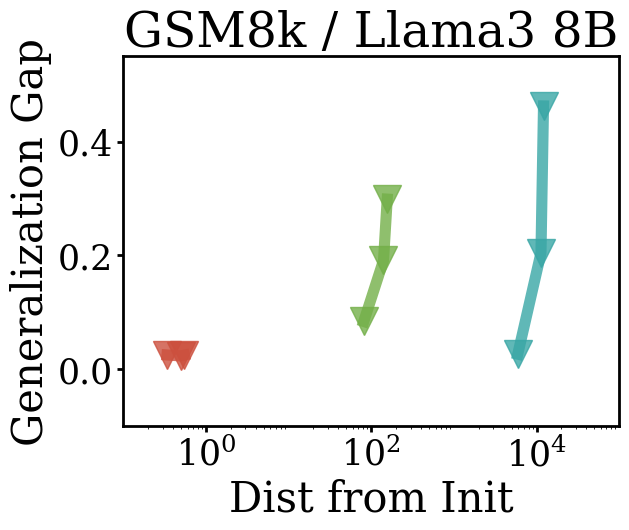

In [37]:
# plt.plot(ratios_dict5_3["unmemorized_acc_cummax"], ratios_dict5_3["avg_test_acc"], "v-", markersize=10, c="C0", alpha=0.8, label="lr 5e-5 epochs 3")
fig, ax = plt.subplots()

plt.plot(weight_norms_52, stats_dict52_3["train_accs_all"].mean(axis=1)-ratios_dict52_3["avg_test_acc"], "v-", markersize=20, linewidth = 8, c=color_dict["2e-5"], alpha=0.8, label="lr 2e-5")
plt.plot(weight_norms_4, stats_dict4_3["train_accs_all"].mean(axis=1)-ratios_dict4_3["avg_test_acc"], "v-", markersize=20, linewidth = 8, c=color_dict["2e-4"], alpha=0.8, label="lr 2e-4")
plt.plot(weight_norms_7, stats_dict7_3["train_accs_all"].mean(axis=1)-ratios_dict7_3["avg_test_acc"], "v-", markersize=20, linewidth = 8, c=color_dict["5e-7"], alpha=0.8, label="lr 5e-7")


plt.xlim(0.1, 10e4)
plt.ylim(-0.1, 0.55)

# log scale
plt.xscale("log")
# ax.set_xticks([1, 10e3, 10e4])  # Set custom tick locations

plt.xticks(np.array([1, 10e1, 10e3]), fontsize=25)
plt.yticks([0, 0.2, 0.4], fontsize=25)

#border width
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.tick_params(width=2, length=4)





plt.xlabel("Dist from Init", fontsize=30)
plt.ylabel("Generalization Gap", fontsize=30)
plt.title("GSM8k / Llama3 8B", fontsize=35)

In [22]:
x = np.concatenate([weight_norms_52, weight_norms_4, weight_norms_7])
y = np.concatenate([stats_dict52_3["train_accs_all"].mean(axis=1)-ratios_dict52_3["avg_test_acc"],
                    stats_dict4_3["train_accs_all"].mean(axis=1)-ratios_dict4_3["avg_test_acc"],
                    stats_dict7_3["train_accs_all"].mean(axis=1)-ratios_dict7_3["avg_test_acc"]])

tau, p_value = kendalltau(x, y)
print(tau)

print(pearsonr(x, y))

0.6666666666666666
PearsonRResult(statistic=0.5854716565593779, pvalue=0.09765314199665913)


In [15]:
calibration_file_name = "ckpts/gsm8k_orig_3epochs_full2_lr2e-05_bs128/checkpoint-174"


train_probs = np.e**np.load(calibration_file_name+"/train_log_probs1_seed2_temp0.0.npy")
test_acc = ratios_dict52_3["avg_test_acc"][-1]


threshold = np.percentile(train_probs.squeeze(), (1-test_acc)*100)

In [16]:
ckpts = [58, 116, 174]

file_name = "gsm8k_orig_3epochs_full2_lr0.0002_bs128"
predicted_test_accs_4 = []
for ckpt in ckpts:
    train_probs = np.e**np.load(f"ckpts/{file_name}/checkpoint-{ckpt}/train_log_probs1_seed2_temp0.0.npy")
    predicted_test_accs_4.append((train_probs>threshold).mean())
    
file_name = "gsm8k_orig_3epochs_full2_lr2e-05_bs128"
predicted_test_accs_52 = []
for ckpt in ckpts:
    train_probs = np.e**np.load(f"ckpts/{file_name}/checkpoint-{ckpt}/train_log_probs1_seed2_temp0.0.npy")
    predicted_test_accs_52.append((train_probs>threshold).mean())

file_name = "gsm8k_orig_3epochs_full2_lr5e-07_bs128"
predicted_test_accs_7 = []
for ckpt in ckpts:
    train_probs = np.e**np.load(f"ckpts/{file_name}/checkpoint-{ckpt}/train_log_probs1_seed2_temp0.0.npy")
    predicted_test_accs_7.append((train_probs>threshold).mean())
    

In [17]:
predicted_test_accs_4 = np.array(predicted_test_accs_4)
predicted_test_accs_52 = np.array(predicted_test_accs_52)
predicted_test_accs_7 = np.array(predicted_test_accs_7)

Text(0.5, 1.0, 'GSM8k / Llama3 8B')

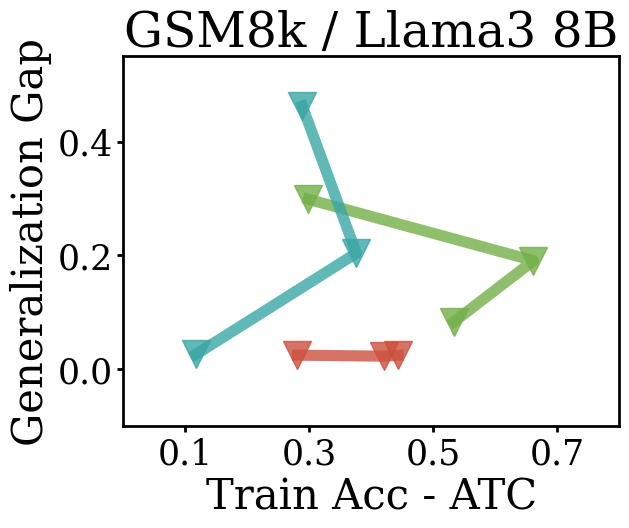

In [41]:
# plt.plot(ratios_dict5_3["unmemorized_acc_cummax"], ratios_dict5_3["avg_test_acc"], "v-", markersize=10, c="C0", alpha=0.8, label="lr 5e-5 epochs 3")
fig, ax = plt.subplots()

plt.plot(stats_dict52_3["train_accs_all"].mean(axis=1)-predicted_test_accs_52, stats_dict52_3["train_accs_all"].mean(axis=1)-ratios_dict52_3["avg_test_acc"], "v-", markersize=20, linewidth = 8, c=color_dict["2e-5"], alpha=0.8, label="lr 2e-5")
plt.plot(stats_dict4_3["train_accs_all"].mean(axis=1)-predicted_test_accs_4, stats_dict4_3["train_accs_all"].mean(axis=1)-ratios_dict4_3["avg_test_acc"], "v-", markersize=20, linewidth = 8, c=color_dict["2e-4"], alpha=0.8, label="lr 2e-4")
plt.plot(stats_dict7_3["train_accs_all"].mean(axis=1)-predicted_test_accs_7, stats_dict7_3["train_accs_all"].mean(axis=1)-ratios_dict7_3["avg_test_acc"], "v-", markersize=20, linewidth = 8, c=color_dict["5e-7"], alpha=0.8, label="lr 5e-7")


plt.xlim(0., 0.8)
plt.ylim(-0.1, 0.55)

# log scale
# ax.set_xticks([1, 10e3, 10e4])  # Set custom tick locations

plt.xticks(np.array([0.1, 0.3, 0.5, 0.7]), fontsize=25)
plt.yticks([0, 0.2, 0.4], fontsize=25)

#border width
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.tick_params(width=2, length=4)




plt.xlabel("Train Acc - ATC", fontsize=30)
plt.ylabel("Generalization Gap", fontsize=30)
plt.title("GSM8k / Llama3 8B", fontsize=35)

In [23]:
x = np.concatenate([stats_dict52_3["train_accs_all"].mean(axis=1)-predicted_test_accs_52,
                    stats_dict4_3["train_accs_all"].mean(axis=1)-predicted_test_accs_4,
                    stats_dict7_3["train_accs_all"].mean(axis=1)-predicted_test_accs_7])

y = np.concatenate([stats_dict52_3["train_accs_all"].mean(axis=1)-ratios_dict52_3["avg_test_acc"],
                    stats_dict4_3["train_accs_all"].mean(axis=1)-ratios_dict4_3["avg_test_acc"],
                    stats_dict7_3["train_accs_all"].mean(axis=1)-ratios_dict7_3["avg_test_acc"]])

tau, p_value = kendalltau(x, y)

print(tau)

print(pearsonr(x, y))

-0.1111111111111111
PearsonRResult(statistic=-0.038468634463796704, pvalue=0.9217289197691562)
